## 範例重點
* 學習如何在 keras 中加入 reduce learning rate
* 知道如何設定 reduce_lr 的監控目標
* 比較使用有無使用 reduce_lr 時的 performance

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss
"""
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batc

Epoch 43/50
50000/50000 [==============================] - 9s 176us/step - loss: 0.8455 - acc: 0.7243 - val_loss: 1.4478 - val_acc: 0.5053

Epoch 00043: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 44/50
50000/50000 [==============================] - 9s 171us/step - loss: 0.8438 - acc: 0.7249 - val_loss: 1.4471 - val_acc: 0.5076
Epoch 45/50
50000/50000 [==============================] - 9s 179us/step - loss: 0.8420 - acc: 0.7268 - val_loss: 1.4479 - val_acc: 0.5063
Epoch 46/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.8420 - acc: 0.7271 - val_loss: 1.4481 - val_acc: 0.5059
Epoch 47/50
50000/50000 [==============================] - 9s 176us/step - loss: 0.8398 - acc: 0.7262 - val_loss: 1.4485 - val_acc: 0.5061
Epoch 48/50
50000/50000 [==============================] - 8s 158us/step - loss: 0.8401 - acc: 0.7267 - val_loss: 1.4484 - val_acc: 0.5070

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Ep

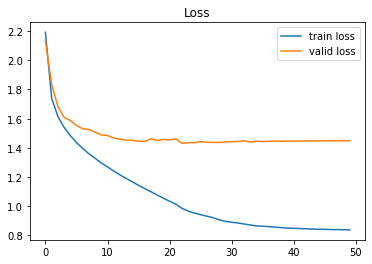

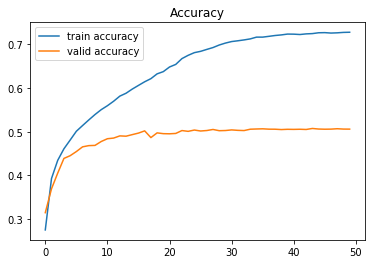

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果